# Hovercraft 1D example

In [1]:
using JuMP, Mosek

m = Model(solver=MosekSolver(LOG=0))

T = 50                  # length of time horizon
@variable(m, x[1:T])    # resulting position
@variable(m, v[1:T])    # resulting velocity
@variable(m, u[1:T-1])  # thruster input

# constraint on start and end positions and velocities
@constraint(m, x[1] == 0)
@constraint(m, v[1] == 0)
@constraint(m, x[T] == 100)
@constraint(m, v[T] == 0)

# satisfy the dynamics
for i = 1:T-1
    @constraint(m, x[i+1] == x[i] + v[i])
    @constraint(m, v[i+1] == v[i] + u[i])
end

# minimize 2-norm
@objective(m, Min, sum(u.^2) )

solve(m)
uopt = getvalue(u);

## Plot optimal input

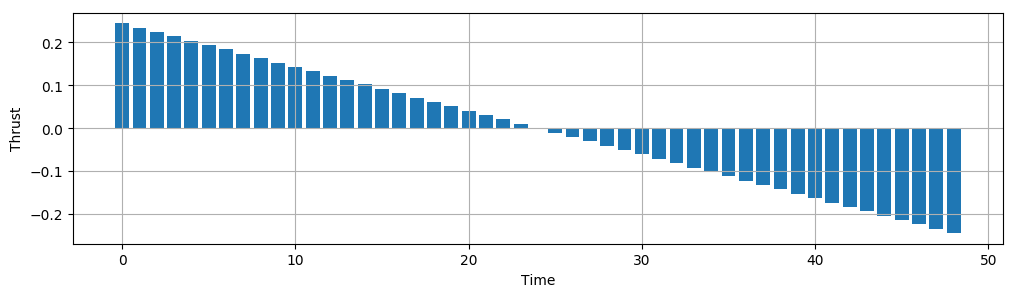

In [2]:
using PyPlot
figure(figsize=(12,3))
bar( 0:T-2, uopt );
xlabel("Time"); ylabel("Thrust"); grid()

## More compact solution

In [20]:
using JuMP, Mosek

T = 50      # length of time horizon

m = Model(solver=MosekSolver(LOG=0))

@variable(m, u[1:T-1])  # thruster input

A = [(48:-1:0)'; ones(1,49)]
b = [100; 0]

@constraint(m, A*u .== b)

# 1-norm
@variable(m, t[1:T-1])
@constraint(m, u .<= t )
@constraint(m, -t .<= u )

# ∞-norm
@variable(m, r)
@constraint(m, u .<= r )
@constraint(m, -r .<= u )

case = :everything
λ = 1

if case == :two
    @objective(m, Min, sum(u.^2))
elseif case == :one
    @objective(m, Min, sum(t))
elseif case == :inf
    @objective(m, Min, r)
elseif case == :two_one
    @objective(m, Min, sum(u.^2) + λ*sum(t))  # lasso
elseif case == :two_inf
    @objective(m, Min, sum(u.^2) + λ*r)  # L-inf regularization
elseif case == :inf_one
    @objective(m, Min, r + λ*sum(t))
elseif case == :everything
    @objective(m, Min, sum(u.^2) + sum(t) + r)
end
    
solve(m)
uopt = getvalue(u);

MOSEK warning 710: #1 (nearly) zero elements are specified in sparse col '' (48) of matrix 'A'.


## Plot optimal input

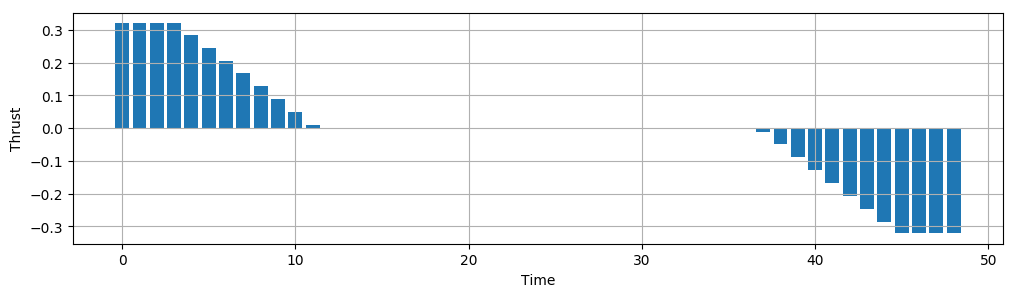

In [21]:
using PyPlot
figure(figsize=(12,3))
bar( 0:T-2, uopt );
xlabel("Time"); ylabel("Thrust"); grid()
#savefig(string("hover_",case,".pdf"));